# NB03: Gene Module Discovery

**Project**: ADP1 Deletion Collection Phenotype Analysis

**Goal**: Cluster 2,034 genes by their 8-condition growth profiles to identify functionally coherent gene modules. Perform functional enrichment analysis per module.

**Input**: `data/growth_matrix_complete.csv`

**Outputs**:
- `data/gene_modules.csv` — gene-to-module assignments
- `data/module_enrichment.csv` — enrichment results per module
- Clustered heatmap, silhouette analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import fisher_exact
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from statsmodels.stats.multitest import multipletests
import os
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

DATA_DIR = '../data'
FIG_DIR = '../figures'

df = pd.read_csv(os.path.join(DATA_DIR, 'growth_matrix_complete.csv'))

GROWTH_COLS = [
    'mutant_growth_acetate', 'mutant_growth_asparagine',
    'mutant_growth_butanediol', 'mutant_growth_glucarate',
    'mutant_growth_glucose', 'mutant_growth_lactate',
    'mutant_growth_quinate', 'mutant_growth_urea'
]
CONDITION_NAMES = [c.replace('mutant_growth_', '') for c in GROWTH_COLS]

print(f'Loaded {len(df):,} genes × {len(GROWTH_COLS)} conditions')

Loaded 2,034 genes × 8 conditions


## 1. Z-score Normalization and Hierarchical Clustering

In [2]:
# Z-score normalize per condition
X = df[GROWTH_COLS].values
scaler = StandardScaler()
X_z = scaler.fit_transform(X)

print(f'Z-scored matrix: {X_z.shape}')
print(f'Column means after scaling: {X_z.mean(axis=0).round(6)}')
print(f'Column stds after scaling: {X_z.std(axis=0).round(3)}')

Z-scored matrix: (2034, 8)
Column means after scaling: [-0. -0.  0.  0.  0.  0.  0. -0.]
Column stds after scaling: [1. 1. 1. 1. 1. 1. 1. 1.]


In [3]:
# Hierarchical clustering of genes (Ward's method, Euclidean on z-scores)
Z_linkage = linkage(X_z, method='ward', metric='euclidean')
print(f'Linkage matrix shape: {Z_linkage.shape}')

Linkage matrix shape: (2033, 4)


## 2. Optimal Number of Clusters (Silhouette Analysis)

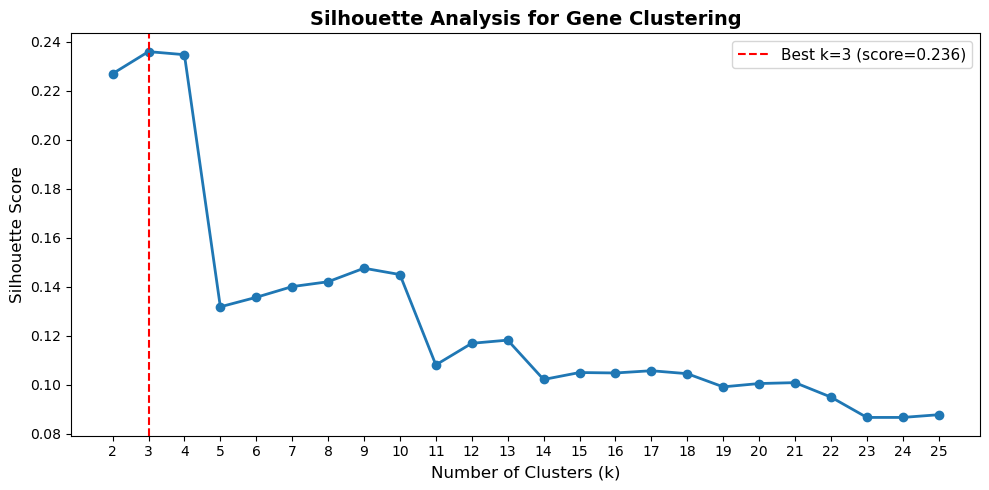

Best k=3 with silhouette=0.236

Top 5 k values:
  k= 3  silhouette=0.236
  k= 4  silhouette=0.235
  k= 2  silhouette=0.227
  k= 9  silhouette=0.147
  k=10  silhouette=0.145


In [4]:
# Test k=2 to k=25
k_range = range(2, 26)
silhouette_scores = []

for k in k_range:
    labels = fcluster(Z_linkage, t=k, criterion='maxclust')
    score = silhouette_score(X_z, labels)
    silhouette_scores.append(score)

best_k = list(k_range)[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(list(k_range), silhouette_scores, 'o-', linewidth=2, markersize=6)
ax.axvline(best_k, color='red', linestyle='--', label=f'Best k={best_k} (score={best_score:.3f})')
ax.set_xlabel('Number of Clusters (k)', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Silhouette Analysis for Gene Clustering', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_xticks(list(k_range))
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'silhouette_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f'Best k={best_k} with silhouette={best_score:.3f}')
print('\nTop 5 k values:')
ranked = sorted(zip(k_range, silhouette_scores), key=lambda x: -x[1])[:5]
for k, s in ranked:
    print(f'  k={k:2d}  silhouette={s:.3f}')

In [5]:
# Use best k (or a biologically reasonable k if best is k=2)
# If best k is very small (2-3), also check the next local peak
# for more biologically informative modules
K = best_k
if best_k <= 3:
    # Also report next local maximum for deeper structure
    for k, s in ranked:
        if k > 3:
            print(f'Alternative: k={k} (silhouette={s:.3f}) for finer-grained modules')
            break

labels = fcluster(Z_linkage, t=K, criterion='maxclust')
df['module'] = labels

print(f'\nUsing K={K} clusters')
print('\nModule sizes:')
for m in sorted(df['module'].unique()):
    n = (df['module'] == m).sum()
    print(f'  Module {m:2d}: {n:>5,} genes')

Alternative: k=4 (silhouette=0.235) for finer-grained modules

Using K=3 clusters

Module sizes:
  Module  1: 1,160 genes
  Module  2:    24 genes
  Module  3:   850 genes


## 3. Module Profiles — Mean Growth per Condition

In [6]:
# Compute mean z-score profile per module
df_z = pd.DataFrame(X_z, columns=CONDITION_NAMES)
df_z['module'] = labels

module_profiles = df_z.groupby('module')[CONDITION_NAMES].mean()

print('=== Module Mean Z-Score Profiles ===')
print(module_profiles.round(2).to_string())

=== Module Mean Z-Score Profiles ===
        acetate  asparagine  butanediol  glucarate  glucose  lactate  quinate  urea
module                                                                             
1           0.6        0.44        0.45       0.24     0.35     0.30     0.25  0.34
2          -0.5       -1.93       -0.08       0.67     0.59    -0.52    -7.28 -0.62
3          -0.8       -0.55       -0.61      -0.34    -0.49    -0.39    -0.14 -0.45


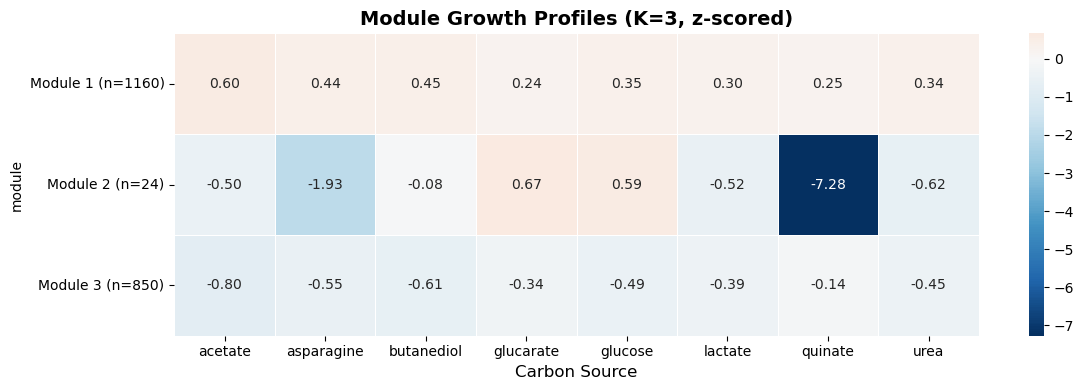

Saved: figures/module_profiles.png


In [7]:
# Profile heatmap
fig, ax = plt.subplots(figsize=(12, max(4, K * 0.5)))

module_sizes = df['module'].value_counts().sort_index()
profile_labels = [f'Module {m} (n={module_sizes[m]})' for m in module_profiles.index]

sns.heatmap(module_profiles, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax, yticklabels=profile_labels, linewidths=0.5)
ax.set_title(f'Module Growth Profiles (K={K}, z-scored)', fontsize=14, fontweight='bold')
ax.set_xlabel('Carbon Source', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'module_profiles.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/module_profiles.png')

## 4. Clustered Heatmap — All 2,034 Genes

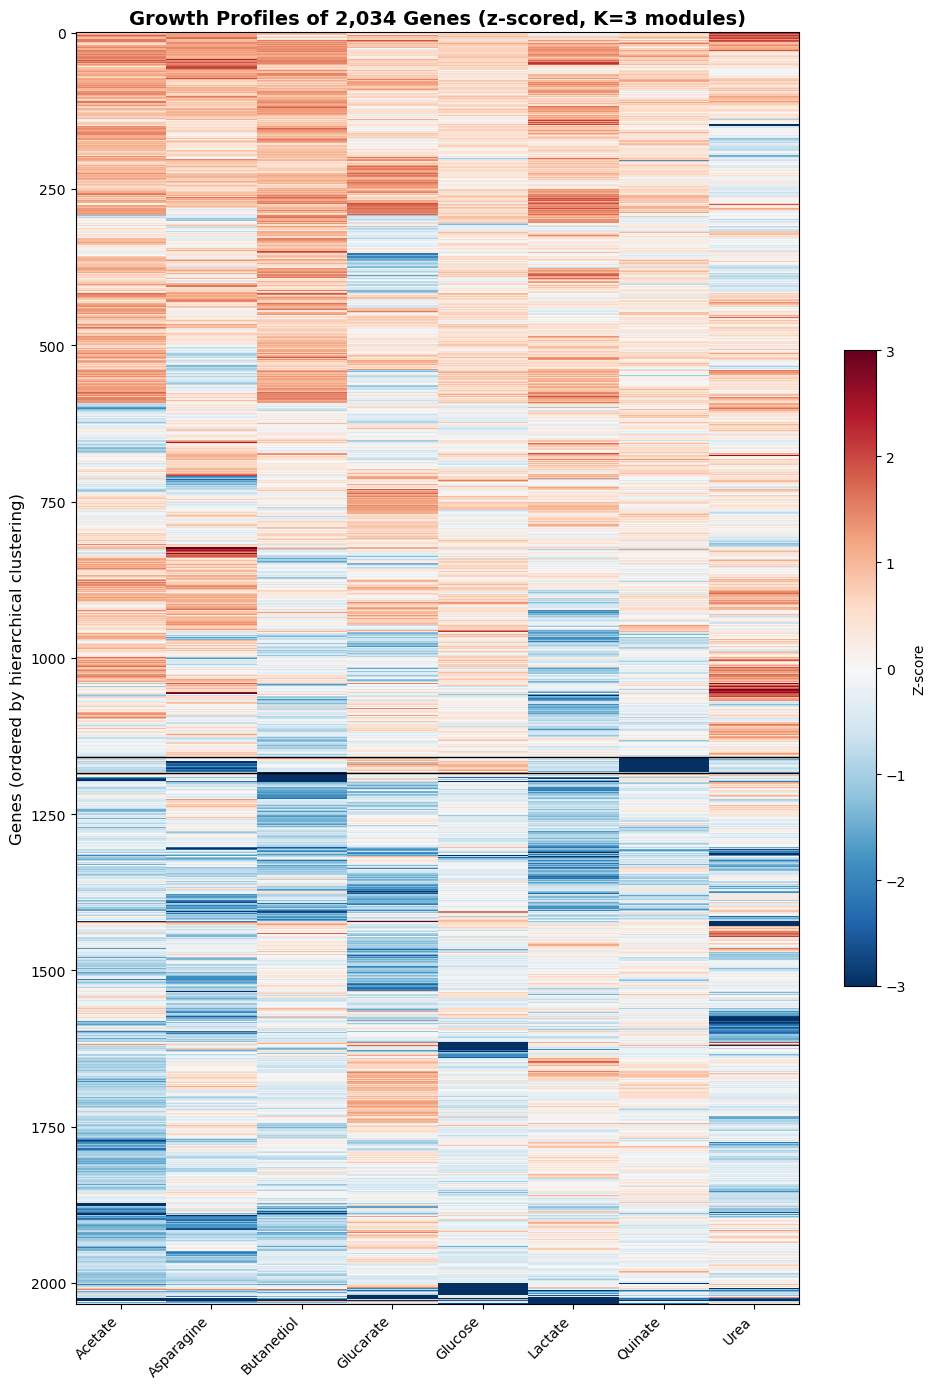

Saved: figures/gene_heatmap.png


In [8]:
# Full clustered heatmap with gene dendrogram
# Sort genes by module assignment and within-module by dendrogram order
from scipy.cluster.hierarchy import leaves_list

gene_order = leaves_list(Z_linkage)
X_z_ordered = X_z[gene_order]

fig, ax = plt.subplots(figsize=(10, 14))
im = ax.imshow(X_z_ordered, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3,
               interpolation='none')
ax.set_xticks(range(8))
ax.set_xticklabels([n.capitalize() for n in CONDITION_NAMES], rotation=45, ha='right')
ax.set_ylabel('Genes (ordered by hierarchical clustering)', fontsize=12)
ax.set_title(f'Growth Profiles of 2,034 Genes (z-scored, K={K} modules)',
             fontsize=14, fontweight='bold')

# Add module boundaries
module_ordered = labels[gene_order]
for i in range(1, len(module_ordered)):
    if module_ordered[i] != module_ordered[i-1]:
        ax.axhline(i - 0.5, color='black', linewidth=1)

plt.colorbar(im, ax=ax, label='Z-score', shrink=0.5)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'gene_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/gene_heatmap.png')

## 5. Functional Enrichment per Module

Fisher's exact test for RAST function enrichment in each module. Benjamini-Hochberg FDR correction across all tests.

In [9]:
# Parse RAST functions — use the first function if multiple
df['rast_clean'] = df['rast_function'].fillna('Hypothetical').apply(
    lambda x: x.split(' / ')[0] if pd.notna(x) else 'Hypothetical'
)

# Get RAST function counts in the full dataset
total_n = len(df)
rast_counts = df['rast_clean'].value_counts()

# Only test functions that appear >= 5 times
testable_functions = rast_counts[rast_counts >= 5].index.tolist()
print(f'Testable RAST functions (>=5 genes): {len(testable_functions)}')
print(f'Total RAST categories: {len(rast_counts)}')

# Fisher's exact test for each module × function
enrichment_results = []
for module_id in sorted(df['module'].unique()):
    module_genes = df[df['module'] == module_id]
    module_n = len(module_genes)
    
    for func in testable_functions:
        # 2x2 contingency: module vs not-module × function vs not-function
        a = (module_genes['rast_clean'] == func).sum()  # in module, has function
        b = module_n - a  # in module, no function
        c = (df['rast_clean'] == func).sum() - a  # not in module, has function
        d = total_n - module_n - c  # not in module, no function
        
        if a >= 2:  # Only report if >=2 genes in module have this function
            odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='greater')
            enrichment_results.append({
                'module': module_id,
                'function': func,
                'module_count': a,
                'module_size': module_n,
                'total_count': a + c,
                'odds_ratio': odds_ratio,
                'p_value': p_value
            })

df_enrich = pd.DataFrame(enrichment_results)
print(f'Total tests performed: {len(df_enrich):,}')

Testable RAST functions (>=5 genes): 19
Total RAST categories: 1446
Total tests performed: 35


In [10]:
# BH-FDR correction
if len(df_enrich) > 0:
    reject, qvals, _, _ = multipletests(df_enrich['p_value'], method='fdr_bh', alpha=0.05)
    df_enrich['q_value'] = qvals
    df_enrich['significant'] = reject
    
    sig = df_enrich[df_enrich['significant']].sort_values('q_value')
    print(f'Significant enrichments (q<0.05): {len(sig)}')
    print(f'Modules with enrichments: {sig["module"].nunique()} / {K}')
    print()
    
    # Top enrichments per module
    print('=== Top Enrichments per Module ===')
    for module_id in sorted(sig['module'].unique()):
        mod_sig = sig[sig['module'] == module_id].head(5)
        print(f'\nModule {module_id} ({(df["module"]==module_id).sum()} genes):')
        for _, row in mod_sig.iterrows():
            print(f'  {row["function"][:60]:60s} '
                  f'{row["module_count"]:>3}/{row["module_size"]:>4} '
                  f'(total={row["total_count"]:>3}) '
                  f'OR={row["odds_ratio"]:>6.1f} q={row["q_value"]:.1e}')
else:
    print('No enrichment tests to perform')

Significant enrichments (q<0.05): 0
Modules with enrichments: 0 / 3

=== Top Enrichments per Module ===


## 6. PFAM Domain Enrichment

In [11]:
# Parse PFAM — can have multiple domains per gene
pfam_genes = df[df['pfam'].notna()].copy()
print(f'Genes with PFAM annotations: {len(pfam_genes)} / {len(df)}')

# Explode multi-domain entries
pfam_expanded = []
for _, row in pfam_genes.iterrows():
    domains = [d.strip() for d in str(row['pfam']).split(',')]
    for d in domains:
        if d and d != 'nan':
            pfam_expanded.append({'feature_id': row['feature_id'], 'module': row['module'], 'pfam_domain': d})

df_pfam = pd.DataFrame(pfam_expanded)
print(f'Gene-domain pairs: {len(df_pfam):,}')
print(f'Unique domains: {df_pfam["pfam_domain"].nunique()}')

# Top domains by frequency
top_domains = df_pfam['pfam_domain'].value_counts().head(15)
print('\nTop 15 PFAM domains:')
print(top_domains.to_string())

Genes with PFAM annotations: 2012 / 2034
Gene-domain pairs: 2,012
Unique domains: 1193

Top 15 PFAM domains:
pfam_domain
PF03466    18
PF00106    16
PF04055    12
PF07715    12
PF05043    12
PF07690    11
PF02771    11
PF00593    11
PF00005    10
PF00171    10
PF00392     9
PF11877     8
PF00296     8
PF00873     8
PF00892     8


In [12]:
# PFAM enrichment per module (Fisher's exact, BH-FDR)
pfam_counts = df_pfam.groupby('pfam_domain')['feature_id'].nunique()
testable_pfam = pfam_counts[pfam_counts >= 5].index.tolist()
print(f'Testable PFAM domains (>=5 genes): {len(testable_pfam)}')

# Gene sets per module (using feature_id for unique genes)
pfam_enrich = []
for module_id in sorted(df['module'].unique()):
    module_features = set(df[df['module'] == module_id]['feature_id'])
    module_pfam = df_pfam[df_pfam['feature_id'].isin(module_features)]
    module_n = len(module_features)
    
    for domain in testable_pfam:
        genes_with_domain_in_module = module_pfam[module_pfam['pfam_domain'] == domain]['feature_id'].nunique()
        total_with_domain = df_pfam[df_pfam['pfam_domain'] == domain]['feature_id'].nunique()
        
        if genes_with_domain_in_module >= 2:
            a = genes_with_domain_in_module
            b = module_n - a
            c = total_with_domain - a
            d = total_n - module_n - c
            
            odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='greater')
            pfam_enrich.append({
                'module': module_id,
                'domain': domain,
                'module_count': a,
                'module_size': module_n,
                'total_count': total_with_domain,
                'odds_ratio': odds_ratio,
                'p_value': p_value
            })

df_pfam_enrich = pd.DataFrame(pfam_enrich)
if len(df_pfam_enrich) > 0:
    reject, qvals, _, _ = multipletests(df_pfam_enrich['p_value'], method='fdr_bh', alpha=0.05)
    df_pfam_enrich['q_value'] = qvals
    df_pfam_enrich['significant'] = reject
    
    sig_pfam = df_pfam_enrich[df_pfam_enrich['significant']].sort_values('q_value')
    print(f'Significant PFAM enrichments (q<0.05): {len(sig_pfam)}')
    
    if len(sig_pfam) > 0:
        print('\n=== Top PFAM Enrichments ===')
        for module_id in sorted(sig_pfam['module'].unique()):
            mod_sig = sig_pfam[sig_pfam['module'] == module_id].head(3)
            print(f'\nModule {module_id}:')
            for _, row in mod_sig.iterrows():
                print(f'  {row["domain"]:20s} {row["module_count"]:>3}/{row["module_size"]:>4} '
                      f'(total={row["total_count"]:>3}) OR={row["odds_ratio"]:>6.1f} q={row["q_value"]:.1e}')

Testable PFAM domains (>=5 genes): 58


Significant PFAM enrichments (q<0.05): 0


## 7. Save Module Assignments and Enrichment Results

In [13]:
# Save gene module assignments
df.to_csv(os.path.join(DATA_DIR, 'gene_modules.csv'), index=False)
print(f'Saved: data/gene_modules.csv ({len(df):,} rows)')

# Save enrichment results
all_enrich = []
if len(df_enrich) > 0:
    rast_sig = df_enrich[df_enrich['significant']].copy()
    rast_sig['annotation_type'] = 'RAST'
    rast_sig = rast_sig.rename(columns={'function': 'term'})
    all_enrich.append(rast_sig)

if len(df_pfam_enrich) > 0:
    pfam_sig = df_pfam_enrich[df_pfam_enrich['significant']].copy()
    pfam_sig['annotation_type'] = 'PFAM'
    pfam_sig = pfam_sig.rename(columns={'domain': 'term'})
    all_enrich.append(pfam_sig)

if all_enrich:
    df_all_enrich = pd.concat(all_enrich, ignore_index=True)
    df_all_enrich.to_csv(os.path.join(DATA_DIR, 'module_enrichment.csv'), index=False)
    print(f'Saved: data/module_enrichment.csv ({len(df_all_enrich):,} enrichments)')
else:
    print('No significant enrichments to save')

print(f'\n=== NB03 Summary ===')
print(f'Genes clustered: {len(df):,}')
print(f'Modules (K): {K}')
print(f'Silhouette score: {best_score:.3f}')
if len(df_enrich) > 0:
    print(f'RAST enrichments (q<0.05): {df_enrich["significant"].sum()}')
if len(df_pfam_enrich) > 0:
    print(f'PFAM enrichments (q<0.05): {df_pfam_enrich["significant"].sum()}')

Saved: data/gene_modules.csv (2,034 rows)
Saved: data/module_enrichment.csv (0 enrichments)

=== NB03 Summary ===
Genes clustered: 2,034
Modules (K): 3
Silhouette score: 0.236
RAST enrichments (q<0.05): 0
PFAM enrichments (q<0.05): 0
